# Exploratory Data Analysis (EDA)

**Topic:** Endangered species

**Data source:** [International Union for Conservation of Nature’s Red List of Threatened Species](https://www.iucnredlist.org/)

**Goal:** The present notebook aims to join several files obtained through web scrapping and official sources from the IUCN Red List to create a dataset with information about endangered species worldwide. The dataset will serve to develop a web page showing the status of endangered species across the globe. After preprocessing the data, an exploratory data analysis will be done to understand the data and get insights from it.

#### Import required libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

from tqdm import tqdm

#### Utils

In [2]:
def save_json(dictionary, filename):
    if os.path.exists(filename):
        os.remove(filename)
        
    with open(filename, 'w') as f:
        json.dump(dictionary, f)
        print(f"Saved data to {filename}")

#### Preprocessing

1. Load data and join files to have a single dataset

In [3]:
def join_files(raw_data_path, species_path, output_path):
    animals = []

    df_species = pd.read_csv(species_path)

    try:
        print("Joining files to create a single dataset...")

        for folder_id in tqdm(os.listdir(raw_data_path), desc="Processing files"):
            animal = {
                "id": folder_id,
            }

            animal.update(df_species[df_species['id_no'] == int(folder_id)].to_dict(orient='records')[0])

            # join all json files
            path = f"{raw_data_path}/{folder_id}"

            if os.path.exists(path):
                narrative_data = pd.read_json(f"{path}/narrative.json")["result"][0]
                animal.update(narrative_data)

                species = pd.read_json(f"{path}/species.json")["result"][0]
                animal.update(species)
                
                data_files = ['countries', 'habitats', 'history', 'threats']
                for file_name in data_files:
                    animal[file_name] = pd.read_json(f"{path}/{file_name}.json")["result"].tolist()

                animals.append(animal)
        
        save_json(animals, output_path)
    except Exception as e:
        print(e)

In [4]:
raw_data_path = './data_viz_animals/raw_data'
species_path = './data_viz_animals/species.csv'
output_path = './data_viz_animals/animals.json'

join_files(raw_data_path, species_path, output_path)

Joining files to create a single dataset...


Processing files: 100%|██████████| 1799/1799 [00:08<00:00, 211.44it/s]


Saved data to ./data_viz_animals/animals.json


### Exploratory Data Analysis

1. General information about the dataset

In [5]:
df_animals = pd.read_json('./data_viz_animals/animals.json')
df_animals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1799 entries, 0 to 1798
Data columns (total 64 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1799 non-null   int64  
 1   assessment_id         1799 non-null   int64  
 2   id_no                 1799 non-null   int64  
 3   sci_name              1799 non-null   object 
 4   presence              1799 non-null   int64  
 5   origin                1799 non-null   int64  
 6   seasonal              1799 non-null   int64  
 7   compiler              1798 non-null   object 
 8   yrcompiled            1799 non-null   int64  
 9   citation              1798 non-null   object 
 10  legend                1799 non-null   object 
 11  subspecies            756 non-null    object 
 12  subpop                748 non-null    object 
 13  dist_comm             497 non-null    object 
 14  island                835 non-null    object 
 15  tax_comm              331 

2. Clean data and check for missing values

In [6]:
def clean_animals_data(df_animals):
    columns_to_drop = [
        'subspecies', 'subpop', 'dist_comm', 'island', 'tax_comm', 
        'taxonomicnotes', 'main_common_name', 'aoo_km2', 'eoo_km2', 
        'elevation_upper', 'elevation_lower', 'depth_upper', 'depth_lower', 
        'errata_flag', 'errata_reason', 'amended_flag', 'amended_reason',
        'id_no', 'species_id', 'assessment_id', 'origin', 'presence', 
        'seasonal', 'assessor', 'reviewer'
    ]
    
    print("Removing columns with many missing values, duplicated, or no meaningful information...")
    df_animals = df_animals.drop(columns=columns_to_drop)

    return df_animals

In [7]:
df_animals = clean_animals_data(df_animals)
df_animals.info()

Removing columns with many missing values...
Removing columns with many missing values, duplicated, or no meaningful information...
<class 'pandas.core.frame.DataFrame'>
Index: 1799 entries, 0 to 1798
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1799 non-null   int64  
 1   sci_name              1799 non-null   object 
 2   compiler              1798 non-null   object 
 3   yrcompiled            1799 non-null   int64  
 4   citation              1798 non-null   object 
 5   legend                1799 non-null   object 
 6   source                1468 non-null   object 
 7   basisofrec            1233 non-null   object 
 8   event_year            1577 non-null   float64
 9   longitude             1799 non-null   float64
 10  latitude              1799 non-null   float64
 11  rationale             1799 non-null   object 
 12  geographicrange       1799 non-null   object 
 

#### Explore the dataset

In [8]:
df_animals.head()

,id,sci_name,compiler,yrcompiled,citation,legend,source,basisofrec,event_year,longitude,...,assessment_date,category,criteria,population_trend,marine_system,freshwater_system,terrestrial_system,countries,habitats,history
0,192897,Herichthys labridens,"Fabian Pérez, Omar Mejía, Eduardo Soto-Galera...",2018,IUCN (International Union for Conservation of ...,Extant (resident),ENCB-IPN-P1888,PRESERVED_SPECIMEN,1955.0,-100.048330,...,2018-10-18,EN,B1ab(iii),Decreasing,False,True,False,"[{'code': 'MX', 'country': 'Mexico', 'presence...","[{'code': '5.1', 'habitat': 'Wetlands (inland)...","[{'year': '2019', 'assess_year': '2018', 'code..."
1,139371719,Onychogomphus thienemanni,R.A. Dow,2019,R.A. Dow,Extant (resident),Choong & Rahim 2014,PreservedSpecimen,2010.0,101.987900,...,2019-05-26,NT,None,Decreasing,False,True,True,"[{'code': 'ID', 'country': 'Indonesia', 'prese...","[{'code': '1.6', 'habitat': 'Forest - Subtropi...","[{'year': '2020', 'assess_year': '2019', 'code..."
2,176408492,Andromakhe latens,"Alonso, F.A.",2020,IUCN (International Union for Conservation of ...,Extant (resident),None,None,NaN,-64.500597,...,2020-12-14,EN,B1ab(iii),Unknown,False,True,False,"[{'code': 'AR', 'country': 'Argentina', 'prese...","[{'code': '5.1', 'habitat': 'Wetlands (inland)...","[{'year': '2022', 'assess_year': '2020', 'code..."
3,197975,Caridina striata,"K. von Rintelen, MfN Berlin",2017,"K. von Rintelen, MfN Berlin",Extant (resident),"von Rintelen K., and Y. Cai. 2009. The Raffles...",PreservedSpecimen,2003.0,121.396333,...,2018-12-06,CR,A3e,Unknown,False,True,False,"[{'code': 'ID', 'country': 'Indonesia', 'prese...","[{'code': '5.5', 'habitat': 'Wetlands (inland)...","[{'year': '2019', 'assess_year': '2018', 'code..."
4,218123787,Ancylodactylus spawlsi,PK Malonza,2022,National Museums of Kenya (NMK),Extant (resident),NMK,PreservedSpecimen,2013.0,37.129850,...,2022-07-04,VU,B1ab(iii),Decreasing,False,False,True,"[{'code': 'KE', 'country': 'Kenya', 'presence'...","[{'code': '1.5', 'habitat': 'Forest - Subtropi...","[{'year': '2023', 'assess_year': '2022', 'code..."


3. Plots to understand the data

* Number of species per category, where categories are:
    - NE: Not Evaluated
    - DD: Data Deficient
    - LC: Least Concern
    - NT: Near Threatened
    - VU: Vulnerable
    - EN: Endangered
    - CR: Critically Endangered
    - EW: Extinct in the Wild
    - EX: Extinct

In [9]:
df_categories = df_animals['category'].value_counts()
df_categories = df_categories.rename_axis('category').reset_index(name='counts')
df_categories.head()

,category,counts
0,EN,579
1,VU,502
2,NT,410
3,CR,298
4,EX,9


* Number of animals per habitat: an animal can have more than one habitat

In [10]:
df_habitats = df_animals[['id', 'sci_name', 'habitats']]

habitats = []
for index, row in df_habitats.iterrows():
    for habitat in row['habitats']:
        habitats.append({
            'id': row['id'],
            'sci_name': row['sci_name'],
            'habitat': habitat['habitat']
        })
    
df_habitats = pd.DataFrame(habitats)
df_habitats.head()

,id,sci_name,habitat
0,192897,Herichthys labridens,Wetlands (inland) - Permanent Rivers/Streams/C...
1,192897,Herichthys labridens,Wetlands (inland) - Permanent Freshwater Marsh...
2,139371719,Onychogomphus thienemanni,Forest - Subtropical/Tropical Moist Lowland
3,139371719,Onychogomphus thienemanni,Wetlands (inland) - Permanent Rivers/Streams/C...
4,176408492,Andromakhe latens,Wetlands (inland) - Permanent Rivers/Streams/C...


In [11]:
df_habitats = df_habitats['habitat'].value_counts()
df_habitats = df_habitats.reset_index(name='counts')
df_habitats.head(20)

,habitat,counts
0,Wetlands (inland) - Permanent Rivers/Streams/C...,1033
1,Forest - Subtropical/Tropical Moist Lowland,389
2,Wetlands (inland) - Permanent Freshwater Lakes...,254
3,Forest - Subtropical/Tropical Moist Montane,193
4,Marine Deep Benthic - Deep Sea Vents (Rifts/Se...,159
5,Wetlands (inland) - Permanent Freshwater Marsh...,131
6,"Wetlands (inland) - Bogs, Marshes, Swamps, Fen...",109
7,Wetlands (inland) - Freshwater Springs and Oases,100
8,Forest - Subtropical/Tropical Swamp,91
9,Wetlands (inland) - Seasonal/Intermittent/Irre...,86


* Countries with most endangered species (category = EN)

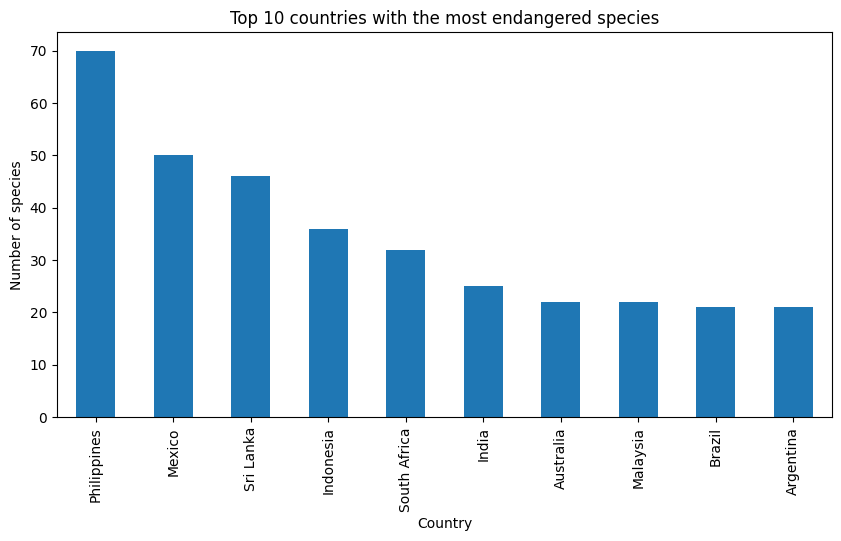

In [12]:
endangered_countries = df_animals[df_animals['category'] == 'EN']['countries']
endangered_countries = [country for countries in endangered_countries for country in countries]
endangered_countries = pd.DataFrame(endangered_countries)['country'].value_counts()

plt.figure(figsize=(10, 5))
endangered_countries.head(10).plot(kind='bar') # by default 10 countries, but it can be changed
plt.title('Top 10 countries with the most endangered species')
plt.ylabel('Number of species')
plt.xlabel('Country')
plt.show()


* Progress of an animal's status over time

Animal: Herichthys labridens, country: Mexico


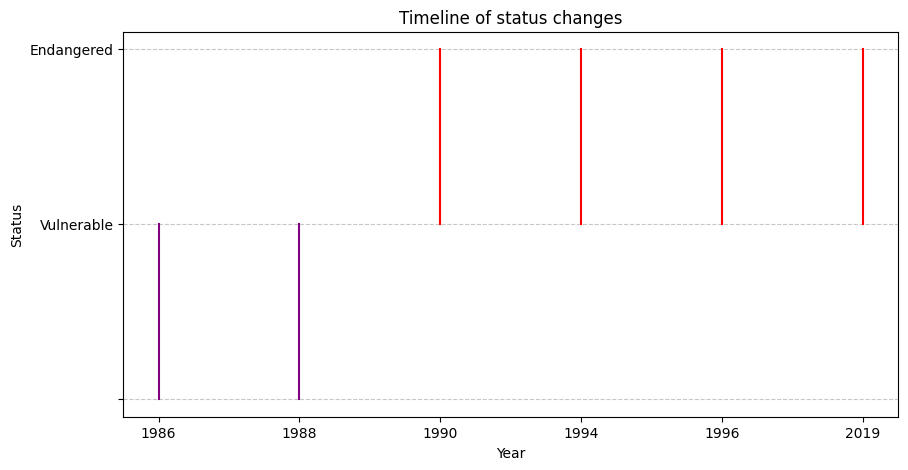

In [13]:
def plot_timeline(data):
    plt.figure(figsize=(10, 5))
    # order data by year
    data = sorted(data, key=lambda x: x['year'])

    for event in data:
        if event['category'] == 'Vulnerable':
            plt.plot([event['year'], event['year']], [0, 0.5], color='purple', label='Vulnerable')
        elif event['category'] == 'Endangered':
            plt.plot([event['year'], event['year']], [0.5, 1], color='red', label='Endangered')
    plt.title('Timeline of status changes')
    plt.xlabel('Year')
    plt.ylabel('Status')
    plt.yticks([0, 0.5, 1], ['', 'Vulnerable', 'Endangered'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


animal = df_animals[df_animals['category'].isin(['EN'])].iloc[0] # by default the first endangered animal in the dataset, but it can be changed
print(f"Animal: {animal['sci_name']}, country: {animal['countries'][0]['country']}")
plot_timeline(df_animals[df_animals['category'].isin(['EN'])]['history'].iloc[0])


* Main threats to animals

In [14]:
threads = df_animals['threats']
threads = [thread for animal_threads in threads for thread in animal_threads]
threads = pd.DataFrame(threads)['title'].value_counts()
threads = threads.rename_axis('thread').reset_index(name='counts')
threads.head(20) # by default 20 threads, but it can be changed

,thread,counts
0,Annual & perennial non-timber crops,819
1,Agricultural & forestry effluents,659
2,Dams & water management/use,634
3,Mining & quarrying,562
4,Logging & wood harvesting,535
5,Scale Unknown/Unrecorded,427
6,Agro-industry farming,409
7,Domestic & urban waste water,391
8,Livestock farming & ranching,371
9,Type Unknown/Unrecorded,333
